# generic bulk model
<p>from mass balance + fick's</p>
<p>r. darling</p>

In [306]:
import numpy as np
from scipy import linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
# hydrogen pump -> local water content ?
# assume RH of feed will give water content
# 100% RH -> water activity of 1, vapor equilibriated
# in nafion, lmbda=14 (water content); transport nums as f(lmdba)

#S = 1.62 mg/kg
S = 2.2e-4 # ratio of hydrogen in surface of electrode to feed
c_feed = 3/1000 # conc of H2 in feed
#c_proton = 0.1 #1.1 #E+3 EW
c_proton = 0

## reference c*_oxidation and c*_reduction
c_H2_0 = 1
c_proton_0 = 1
P_tot = 1 #atm

z = 1
alpha = 0.5
T = 273.15 + 25 # Kelvin
R = 8.314
RT = R*T
E_eq = 0.0
#E = np.arange(-0.3,1.1,0.2)
n = 2

# a_v = 1e6
L = 50e-6 #15e-6
x = np.arange(0, L+0.5e-6, 0.5e-6)
i_0 = 2e-4
F = 96485.3
#D = 0.75e-5 #nafion
A = 0.0050 # prev: 20mm*20mm


---
# Molecular + Knudsen Diffusion

In [222]:
'''
Unfinished. Please do not use this cell !!
'''

v_H2 = 7.07
v_Ar = 16.1
MW_H2 = 2.02
MW_Ar = 39.95 
D_H2_Ar = (0.0017 * T**1.75)/(P_tot *(v_H2**(1/3) + v_Ar**(1/3))**2\
                             ) * np.sqrt(1/MW_H2 + 1/MW_Ar)

d_pore = 100*(10**(-10)) # 100 to 1000 Å 

D_H2_Kn = (1/3)*(d_pore)*np.sqrt((8*RT)/(np.pi*MW_H2)) 

porosity = 0.4
tortuosity = 0.3
D_eff_CL = tortuosity/porosity * (1/D_H2_Ar + 1/D_H2_Kn)


---

In [223]:
# 3M 1000 EW diffusivity
with open('D_3M_1000EW.txt', 'r') as f:
    dt_pair = f.readline()
    dt_vals = dt_pair.split('\t')
    D = float(dt_vals[1])*10**(-6) #diffusion for room temp
f.close()
print(D)

'''
Parameters:
    appplied_potential
    a_v: electrode roughness
    c_feed: inlet feed concentration
    L: thickness of CL
    i_0: charge density
    alpha: # of electrons transferred
Returns:
    current: array of current generated by the cell assuming standard cathode
    conc_cl: array of concentration values across thickness of CL
'''
def c_cl(applied_potential, a_v=1e6, c_feed=3/1000, L=50e-6, i_0=2e-5, alpha=0.5):
    x = np.arange(0, L+0.5e-6, 0.5e-6)
    b = alpha*z*F/RT*(applied_potential-E_eq)
    g = (a_v*i_0) / (c_H2_0*n*F*D) * np.exp(b)
    rt_g = np.sqrt(g)
    om = (c_proton*c_H2_0)/c_proton_0 * np.exp(-b - (1-alpha)/alpha * b)
    conc_cl = om + (c_feed-om)/(np.exp(-2*rt_g*L)+1)*(np.exp(-2*rt_g*L + rt_g*x) + np.exp(-rt_g*x))
    # if c_feed-om < 0:
    #     print('conc')
    # elif (1 - np.exp(-2*rt_g*L)) < 0:
    #     print('exp')
    current = (a_v * i_0 * 1/c_H2_0 * 1/rt_g) * np.exp(b) * (c_feed - om) * (1 - np.exp(-2*rt_g*L)) / (np.exp(-2*rt_g*L) + 1)
    return current, conc_cl


6.623376623376619e-06


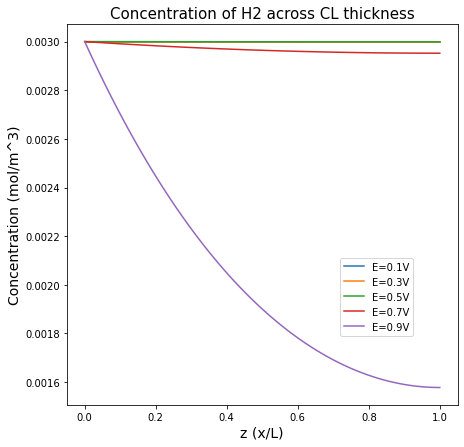

In [224]:
E = np.arange(0.1,1,0.2)
curr = []

plt.figure(figsize=(7,7))
for i in range(len(E)):
    curr1, conc1 = c_cl(E[i])
    curr.append(curr1)
    plt.plot(x/L, conc1, label=('E=' + str(round(E[i],2)) + 'V'))
    
#E=[0.6]
#plt.plot(x/L, c_cl(0), label=(str(round(E[0],2)) + 'V'), color='red')
plt.title('Concentration of H2 across CL thickness', fontsize='15')
plt.ylabel('Concentration (mol/m^3)', fontsize='14')
plt.xlabel('z (x/L)', fontsize='14')
#plt.grid(True,which="both", linestyle='--')
plt.legend(bbox_to_anchor=(0.9,0.4))


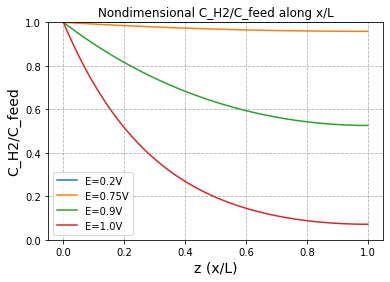

In [225]:
plt.figure()
I = []
E1 = [0.2, .75, .9, 1.0]
# MT limited at ~1.0 V
for i in range(len(E1)):
    curr2, conc2 = c_cl(E1[i])
    plt.plot(x/L, (conc2/c_feed), label=('E=' + str(round(E1[i],2)) + 'V'))
    I = np.append(I, curr2)

plt.title('Nondimensional C_H2/C_feed along x/L')
plt.ylabel('C_H2/C_feed', fontsize='14')
plt.xlabel('z (x/L)', fontsize='14')
plt.grid(True,which="both", linestyle='--')
plt.legend(loc='lower left')
plt.ylim(0,1)
plt.show()


---
# Model vs Experimental

In [226]:
with open('pump_potential.txt', 'r') as f:
    lines = f.readlines()
f.close()

pump_v = [] #potential
pump_a = [] #current
for i in lines:
    vals = i.split("\t")
    pump_a = np.append(pump_a, float(vals[0]))
    pump_v = np.append(pump_v, float(vals[1]))


## Current density

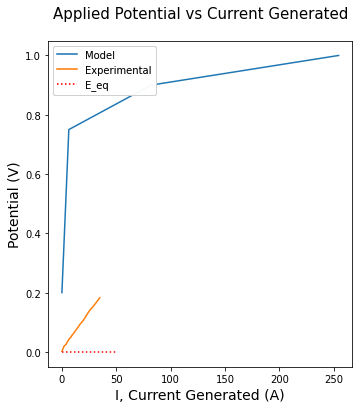

In [227]:
u_v = plt.figure(figsize=(12, 6))
ax = u_v.add_subplot(121)

# model current
model_v = ax.plot(I, E1, label='Model')

# experimental current
exp_v = ax.plot(pump_a, pump_v, label='Experimental')
line1 = ax.hlines(0, xmin=0, xmax=50, color='red', linestyle=':', label='E_eq')

#ax2 = u_v.add_subplot(122)
#ax2.plot(curr,E)
#ax2.hlines(0, xmin=0, xmax=10, color='red',linestyle=':',label='E_eq')
#line2 = plt.axvline(0.875, color='orange',linestyle='-',label='I>0 (~0.875V)')
#ax2.set_xlim([0, 1.25])
#ax2.set_ylim([0, 0.3])

ax.set_title('Applied Potential vs Current Generated', fontsize='15', y=1.05)
ax.set_xlabel('I, Current Generated (A)', fontsize='14')
ax.set_ylabel('Potential (V)', fontsize='14')

leg1 = plt.legend(fontsize=10, loc='upper left')
plt.gca().add_artist(leg1)
plt.show()

---
# film-agglomerate spherical model
based on yoon 2011 (https://sci-hub.se/10.1149/1.3597644)

In [228]:
R_a = 0.1e-6 #0.1 micron, yoon
del_f = 20e-9
R_sph = R_a+del_f

D_agg = 8.45e-9 # O2 diffusion in Yoon = 8.45e-5 cm^2/s
D_CL = 2.30e-5

Df = 0.5e-5 #also check this
i_0 = 2e-4

# perm_H2_I = 5.64e-12 # [m^2/2] H2 permeability in thin film
agg_cl = 0.4 #agglomerate to CL ratio by weight
eps = 0.4 #porosity
L_Pt = 0.167 #0.2 mg Pt cm^-2
A_ca = 40

print(L_Pt*A_ca/L)

133600.0


In [229]:
'''
Parameters:
    * applied_potential: voltage applied to cell
    * x_cl: x along thickness of CL to calculate concentrations
    * L_cl: total thickness of CL, default=50um
Returns:
    * conc (dict) with keys:
        micron: micron-scale concentration profile across thickness of CL
        film: concentration through film at x=x_cl
        agg: concentration through agglomerate (excluding film) for agglomerates at x=x_cl
'''
def constants(applied_potential, x_cl, L_cl=50e-6, c_feed=3/1000, R_a=0.1e-6, del_f=20e-9):
    theta = (i_0*L_Pt*A_ca)/((1-agg_cl)*L_cl*c_H2_0*F)*np.exp(alpha*z*F*(applied_potential-E_eq)/RT)
    phi = np.sqrt(theta*R_sph/D_agg)
    #print("%5.2f, %5.2f" % (phi, R_sph/D_agg))
    omega = D_agg/Df * eps/np.sinh(phi*R_a/R_sph) * (-(R_a/R_sph)*np.sinh(phi*R_a/R_sph) + 
                                      (R_a/R_sph)**2*phi*np.cosh(phi*R_a/R_sph))
    p = (1-eps)*D_agg/(4/3*R_a*D_CL*np.sinh(phi*R_a/R_sph)
               ) * (R_sph/R_a) * ( phi*np.cosh(R_a/R_sph) - (R_sph/R_a)*np.sinh(phi*R_a/R_sph)
                                 ) * eps/(R_sph/R_a*omega - omega + 1)
    rt_p = np.sqrt(abs(p))
    k1 = 1/(1+np.exp(-2*rt_p*L))
    conc_micron = combined_micron_scale(x_cl, k1, rt_p, c_feed)
    c_film_bound = conc_micron / (R_sph/R_a * omega - omega + 1)
    zed_agg = np.linspace(0, R_a/(R_a + del_f), 20)
    zed_film = np.linspace(R_a/(R_a + del_f), 1, 10)
    conc = {'micron': conc_micron,
            'agg': c_agg(zed_agg, phi, c_film_bound),
            'film': c_film(zed_film, conc_micron, omega, c_film_bound), 
            'film boundary': c_film_bound,
            'zed_film': zed_film,
            'zed_agg': zed_agg}
    return conc


'''
Concentration expression for micron scale based on Yoon derivation.
See "combined model" note.
'''
def combined_micron_scale(x, k1, rt_p, c_feed=3/1000):
    return c_feed*((1-k1)*np.exp(rt_p*x) + k1*np.exp(-rt_p*x))


'''
Agglomerate concentration; with reaction. Derivation in Mar 18 notes from Yoon 2011 pdf.
'''
## concentration in agglomerate
def c_agg(zed, c_film_boundary, phi, lmbda=0.6):
    return (1/zed) * lmbda * c_film_boundary * R_a/R_sph * np.sinh(phi*zed) / np.sinh(phi*R_a/R_sph)

'''
Film concentration; no reaction. Derivation in Mar 18 notes from Yoon 2011 pdf.
'''
## concentration in film
def c_film(zed, conc_micron, omega, c_film_boundary):
    return conc_micron + omega*c_film_boundary*(1-1/zed)


/var/folders/ct/2d1sn8wn2yx9c0g28s4rgp680000gn/T/ipykernel_2968/3911856682.py:49: RuntimeWarning: divide by zero encountered in true_divide
  return (1/zed) * lmbda * c_film_boundary * R_a/R_sph * np.sinh(phi*zed) / np.sinh(phi*R_a/R_sph)
/var/folders/ct/2d1sn8wn2yx9c0g28s4rgp680000gn/T/ipykernel_2968/3911856682.py:49: RuntimeWarning: invalid value encountered in multiply
  return (1/zed) * lmbda * c_film_boundary * R_a/R_sph * np.sinh(phi*zed) / np.sinh(phi*R_a/R_sph)
/var/folders/ct/2d1sn8wn2yx9c0g28s4rgp680000gn/T/ipykernel_2968/3911856682.py:49: RuntimeWarning: divide by zero encountered in true_divide
  return (1/zed) * lmbda * c_film_boundary * R_a/R_sph * np.sinh(phi*zed) / np.sinh(phi*R_a/R_sph)
/var/folders/ct/2d1sn8wn2yx9c0g28s4rgp680000gn/T/ipykernel_2968/3911856682.py:49: RuntimeWarning: invalid value encountered in multiply
  return (1/zed) * lmbda * c_film_boundary * R_a/R_sph * np.sinh(phi*zed) / np.sinh(phi*R_a/R_sph)
/var/folders/ct/2d1sn8wn2yx9c0g28s4rgp680000gn/T/ipy

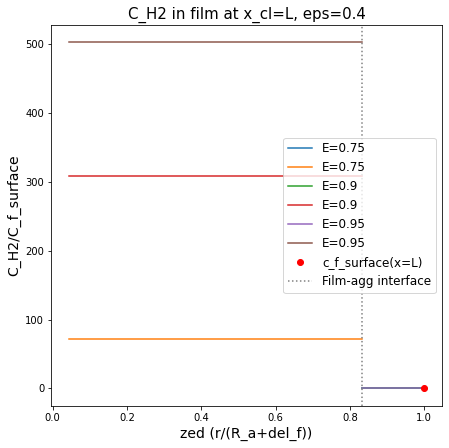

In [230]:
plt.figure(figsize=(7,7))

# TODO: adjust to see x_cl at x=0
# check R_a and R_sph
# changing del_f, R_a, void_factor

# change c_f_surf to reflect L -> micron scale concentration from other plots
zed_i = np.arange(0.05e-8, R_a, 0.05e-8) / R_sph
zed_o = np.arange(R_a, R_sph+0.1*del_f, 0.1*del_f) / R_sph

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#E = [-0.3,0,0.3,0.5,0.6,0.7,0.8]

# film thickness

E1 = [.75, .9, .95]

j=0
for i in range(len(E1)):
    d = constants(E1[i], x_cl=0)
    c_f_surf = d['film boundary']
    plt.plot(d['zed_film'], d['film'], label=('E='+str(E1[i])))
    plt.plot(d['zed_agg'], d['agg'], label=('E='+str(E1[i])))
    j+=1

dot = plt.plot(1,1,'o',color='red',label='c_f_surface(x=L)')
plt.title('C_H2 in film at x_cl=L, eps=0.4', fontsize='15')
plt.ylabel('C_H2/C_f_surface', fontsize='14')
#plt.grid(True,which="both", linestyle='--')
#plt.yscale('log')
plt.xlabel('zed (r/(R_a+del_f))', fontsize='14')
plt.axvline(R_a/R_sph, color='grey', linestyle=':', label='Film-agg interface')

plt.legend(fontsize='12')
#txt = 'Figure 5. Transport through the ionomer film increases with higher overpotential.'
#plt.text(0.5, -0.3, txt, horizontalalignment='center', fontsize=12)
plt.show()

---
## Parameter tuning

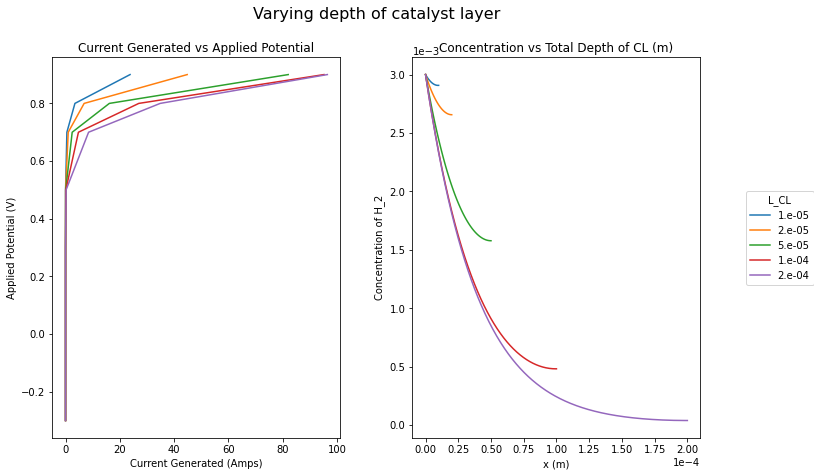

In [231]:
E_test = [-0.3, 0, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]
test_L_arr = [10e-6, 20e-6, 50e-6, 100e-6, 200e-6]

fig_L, axs_L = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12,7))
fig_L.subplots_adjust(right=0.875, wspace=0.25)

for test_L in test_L_arr:
    test_curr = []

    for i in range(len(E_test)):
        # smooth out polarization curve -> exp
        test_i, test_c = c_cl(applied_potential=E_test[i], L=test_L)
        test_curr.append(test_i)

        if E_test[i] == 0.9:
            axs_L[1].plot(
                np.linspace(0, test_L, len(test_c)), test_c,
                label=str(np.round(test_L, 7)) + ' um')

    axs_L[0].plot(
        test_curr, E_test,
        label=np.format_float_scientific(test_L))

axs_L[0].set_xlabel('Current Generated (Amps)')
axs_L[0].set_ylabel('Applied Potential (V)')
axs_L[0].set_title('Current Generated vs Applied Potential')

axs_L[1].set_xlabel('x (m)')
axs_L[1].set_ylabel('Concentration of H_2')
axs_L[1].set_title('Concentration vs Total Depth of CL (m)')
axs_L[1].ticklabel_format(style='sci', scilimits=(0,0))

fig_L.suptitle('Varying depth of catalyst layer', fontsize=16)

handles0, labels0 = axs_L[0].get_legend_handles_labels()
fig_L.legend(handles=handles0,
           labels=labels0,
           loc="center right",
           borderaxespad=0.1,
           title="L_CL"
           )

# beyond 50 um, polarization curves are very similar

Text(0, 0.5, 'Applied Potential (V)')

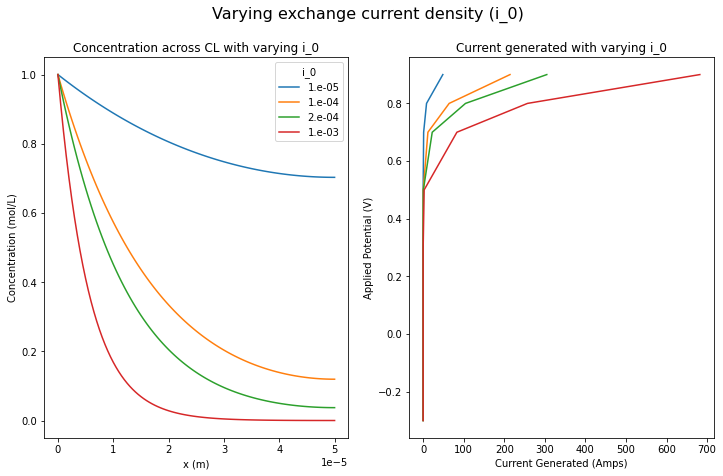

<Figure size 504x504 with 0 Axes>

In [232]:
test_i_0_arr = [1e-5, 1e-4, 2e-4, 10e-4]

fig1, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12,7))
for test_i_0 in test_i_0_arr:
    for i in range(len(E_test)):
        test_i, test_c = c_cl(applied_potential=E_test[i], i_0=test_i_0)
        if E_test[i] == 0.9:
            axs[0].plot(np.linspace(0, L, len(test_c)), test_c/c_feed, label=np.format_float_scientific(test_i_0))
fig1.suptitle('Varying exchange current density (i_0)', fontsize=16)
handles0, labels0 = axs[0].get_legend_handles_labels()
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('Concentration (mol/L)')
axs[0].set_title('Concentration across CL with varying i_0')
axs[0].legend(title='i_0', loc='upper right')

plt.figure(figsize=(7,7))
for test_i_0 in test_i_0_arr:

    test_curr = []
    for i in range(len(E_test)):
        test_i, test_c = c_cl(applied_potential=E_test[i], i_0=test_i_0)
        test_curr.append(test_i)
    axs[1].plot(
        test_curr, E_test,
        label=np.format_float_scientific(test_i_0))

handles1, labels1 = axs[0].get_legend_handles_labels()

axs[1].set_title('Current generated with varying i_0')
axs[1].set_xlabel('Current Generated (Amps)')
axs[1].set_ylabel('Applied Potential (V)')

# i_0 -> exp(-Ea/RT) * roughness_factor
# see Newman ch8

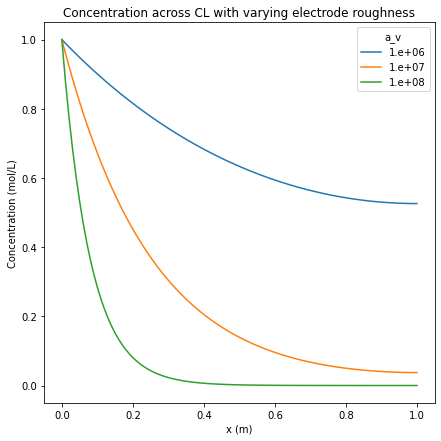

In [233]:
E_param_tuning = 0.2
test_a_v_arr = [1e6, 1e7, 1e8]

plt.figure(figsize=(7,7))
for test_a_v in test_a_v_arr:
    plt.plot(x/L, c_cl(applied_potential=0.9, a_v=test_a_v)[1]/c_feed, label=np.format_float_scientific(test_a_v))

plt.xlabel('x (m)')
plt.ylabel('Concentration (mol/L)')
plt.title('Concentration across CL with varying electrode roughness')
plt.legend(title='a_v')
plt.show()

---
# Combined model

$$
A \left[ -D \frac{\partial c_{bulk}}{\partial x} \mid _{x} - \left( -D \frac{\partial c_{bulk}}{\partial x} \right) \mid _{x+dx} \right] = \left( \frac{\text{rxn rate}}{\text{unit CL vol}} \right) A dx
$$

$$
-D \frac{\partial^2 c_{bulk}}{\partial x^2} = \frac{\text{reaction rate}}{\text{unit CL vol}}
$$

$$ \phi _{CL} = \frac{\text{void vol}}{\text{total CL volume}} $$

$$ \Delta V_{CL} (1-\phi_{CL}) = \text{solid vol in $\Delta V$ CL vol} $$

$$ \text{Num. of aggl. } = \frac{\Delta V_{CL} (1-\phi_{CL})}{\frac{4}{3} \pi R_{agg}^3} $$

$$ \text{Consum. per aggl. } = 4 \pi R_{agg}^2 \left[ -D_{agg} \frac{\partial c_{agg}}{\partial r} \right] $$

$$ \frac{\text{reaction rate}}{\text{unit CL vol}} = \left( \frac{\text{\# aggl.}}{\text{unit vol}}  \right) \left( \frac{\text{consump.}}{\text{aggl.}} \right) $$

$$ -D_{agg} \frac{\partial^2 c_{bulk}}{\partial r^2} = \left( \frac{1-\phi_{CL}}{\frac{4}{3} R_{agg}^3 } \right) \left( 4 \pi R_{agg}^3 \left[ -D_{agg} \frac{\partial c_{agg}}{\partial r} \right] \right) $$

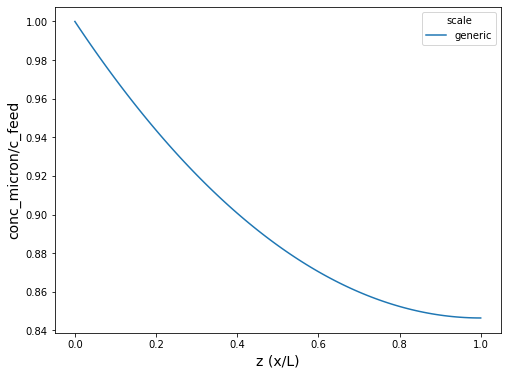

In [234]:
# D_CL: https://escholarship.org/content/qt7kr960nf/qt7kr960nf.pdf
# De: https://sci-hub.se/10.1016/j.ijhydene.2018.07.035
# D_H2mix = 4.9e-5 for r_pore ~ 200nm

j = 0
E_comb = [.9]
L_comb = 50e-6
x_comb = np.arange(0, L+0.5e-6, 0.5e-6)

a_v_match = L_Pt * A_ca / (L * (1-eps))

plt.figure(figsize=(8,6))
for v in E_comb:
    arr_c_micron = []
    i_match, conc_match = c_cl(applied_potential=v, a_v=a_v_match)
    #conc_micron = constants(v, x_comb, L_cl=L_comb)['micron']
    plt.plot(x_comb/L_comb, conc_match/c_feed, label='generic')
    #plt.plot(x_comb/L_comb, conc_micron/c_feed, label='from agg', linestyle='--')

plt.ylabel('conc_micron/c_feed', fontsize='14')
plt.xlabel('z (x/L)', fontsize='14')
plt.legend(title='scale')


---
# Redone model
2022 May 22

In [285]:
E_list = [0, 0.4, 0.5, 0.6, 0.9]
cbulk_plot = []

E_eq = 0

c_feed = 0.4 #mol/m^3, placeholder, 1% Hydrogen in 1 bar ideal gas

alpha_a = 1

S_film_agg = .7
S_bulk_film = .69e-3

cref = 1000 #mol/m^3

F = 96485.3 #C/mol
R = 8.314 #J/mol/K
T = 298 #K


D_film = 1.04e-10 #(m^2) / s, https://pubs.acs.org/doi/abs/10.1021/acs.macromol.5b02578
D_agg = 8.45e-9 #(m^2) / s, from Yoon for Oxygen, need to update

phi_c = 0.1 #Porosity of bulk catalyst layer, Yoon
D_bulk = 5e-5*np.power(phi_c,1.5) #m^2/s, PLACEHOLDER need to update with Bruggeman and find good value
phi_agg = 0 #porosity of interior agglomerate, Yoon

i_0 = 0.002 #A/m^2, HOR, from Rosa's old model

l_cl = 50e-6 #m catalyst layer thickness, Yoon
L_ca = 0.002 #kg/m^2 catalyst loading, Yoon

A_ca = 400000 #(m^2) / kg, ECSA, Yoon

a_v = L_ca*A_ca/l_cl*(1/(1-phi_agg))

R_a = 0.1e-7 #m, Yoon

delta_f = R_a/10 #m, Yoon

a = R_a + delta_f

n_grid = 50
step = l_cl/n_grid
x = np.arange(0, l_cl+step, step)

n_grid_z = 100
step_z = 1/n_grid_z
z = np.arange(step_z, 1+step_z, step_z)
i = 0
cH2_z = []

In [286]:
'''
Calculates concentration across micron scale of the CL at applied potential (E).
Parameters:
    E (double): must be between [0, 1) V
    R_a (float): radius of agglomerate within particle
    phi_agg (double): void factor of agglomerate
Returns: dictionary with
    c_cl: concentration across CL
    a_v, beta, kappa, gamma, xi, nu: constants
    E_r: effectiveness factor
'''
def c_cl_multiscale(E=0.7, R_a=0.1e-6, phi_agg=0.2):

    a_v = L_ca*A_ca/l_cl*(1/(1-phi_agg))
    beta = a_v*i_0/(2*F)*(1/cref)*(np.exp((alpha_a*F/(R*T))*(E-E_eq)))
    kappa = np.sqrt(a*a*beta/D_agg)
    gamma = (-np.sinh(kappa*R_a/a)) + kappa*(R_a/a)*np.cosh(kappa*R_a/a)
    xi = S_bulk_film*S_film_agg/(((a/R_a)*(1/gamma)*(D_film/D_agg)*np.sinh(kappa*R_a/a))+S_film_agg*(delta_f/R_a))
    nu = 3*(1-phi_c)/(a*a)*(D_film/D_bulk)*xi
    sqrt_nu = np.sqrt(nu)

    c_cl = c_feed*(np.cosh(sqrt_nu*x)-np.tanh(sqrt_nu*l_cl)*np.sinh(sqrt_nu*x))
    result = {'c_cl': c_cl,
            'a_v': a_v,
            'beta': beta,
            'kappa': kappa,
            'gamma': gamma,
            'xi': xi,
            'nu': nu,
            'E_r': effectiveness(gamma, kappa, beta, E, R_a)
            }
    return result


'''
Finds effectiveness factor as a function of E and R_a.
'''
def effectiveness(gamma, kappa, beta, E=0.7, R_a=0.1e-6):
    W_AR = D_film*(S_film_agg)/(((a/R_a)*(1/gamma)*(D_film/D_agg)*np.sinh(kappa*R_a/a)+S_film_agg*(delta_f/R_a)))
    W_AR_0 = (1/3)*(a*a)*beta
    return W_AR/W_AR_0


'''
Calculates internal concentration at applied potential (E) and input position in the CL (cl_pos).
Parameters:
    E (double): must be between [0, 1) V
    cl_pos (int): position in array to use
'''
def c_internal(E=0.7, cl_pos=0):

    d_constants = c_cl_multiscale(E=E)

    inv_gamma = 1/d_constants['gamma']
    kappa = d_constants['kappa']
    c_cl = d_constants['c_cl']
    cbulk = c_cl[cl_pos]

    # calculates internal concentration
    cH2_film, cH2_agg = [], []
    for z_val in z:
        if z_val < (R_a)/a:
            c_agg = ((S_bulk_film*S_film_agg*cbulk)/((a/R_a)*inv_gamma*(D_film/D_agg)*np.sinh(kappa*R_a/a)+S_film_agg*(delta_f/R_a)))*inv_gamma*(D_film/D_agg)*np.sinh(kappa*z_val)/(z_val)
            cH2_agg.append(c_agg)
        else:
            c_film = (S_bulk_film*cbulk) + (((S_film_agg*S_bulk_film*cbulk)/((a/R_a)*inv_gamma*(D_film/D_agg)*np.sinh(kappa*R_a/a)+S_film_agg*(delta_f/R_a)))*(1-(1/z_val)))
            cH2_film.append(c_film)

    return cH2_film, cH2_agg


'''
Calculates current for given applied potential values.
Parameters:
    E_list (list): must be between [0, 1) V
'''
def current(R_a=0.1e-6, E_list=E_list):

    i_tot_list = []

    for E in E_list:
        c_agg, _ = c_internal(E=E)
        d = c_cl_multiscale(E=E)
        gamma = d['gamma']
        kappa = d['kappa']
        c_cl = d['c_cl']

        int2 = 0
        curr2 = 0
        for j in range(len(c_cl)):
            cbulk_j = c_cl[j]
            cH2_internal = []
            inv_gamma = 1/gamma
            int1 = 0
            curr = c_cl[0]
            for z_val in z:
                if z_val < (R_a)/a - step_z:
                    cH2 = ((S_bulk_film*S_film_agg*cbulk_j)/((a/R_a)*inv_gamma*(D_film/D_agg)*np.sinh(kappa*R_a/a)+S_film_agg*(delta_f/R_a)))*inv_gamma*(D_film/D_agg)*np.sinh(kappa*z_val)/(z_val)
                    cH2_internal.append(cH2)
                else: 
                    cH2 = 0
                    cH2_internal.append(cH2)
                int1 += step_z*(cH2*z_val*z_val+curr*(z_val-step_z)*(z_val-step_z))/2
                curr = cH2
            if j == 0:
                int2 += step*(int1+curr2)/4
            else:
                int2 += step*(int1+curr2)/2
            curr2 = int1
        i_tot = int2*beta*2*F*(3*(1-phi_c))*0.01
        i_tot_list.append(i_tot)
    
    return i_tot


In [287]:
# E_list = np.arange(0,0.8,0.02)
# cbulk_plot = []
# E_eq = 0

# n_grid = 50
# step = l_cl/n_grid
# x = np.arange(0, l_cl+step, step)

# n_grid_z = 100
# step_z = 1/n_grid_z
# z = np.arange(step_z, 1, step_z)
# i = 0
# cH2_z = []

# radii = [1e-7, 2e-7, 5e-7]
# position = 50

# fig, axs1 = plt.subplots(2, 1, dpi=600, figsize=(4.5,5), sharex='row')
# axs1[0].axes.tick_params(axis="x", direction="in",top=True, labelsize=9)
# axs1[0].axes.tick_params(axis="y", direction="in",right=True, labelsize=9)

# [x.set_linewidth(1.25) for x in axs1[0].spines.values()]
# [x.set_linewidth(1.25) for x in axs1[1].spines.values()]

# #This specifies the number of tick marks on the x and y axis
# axs1[0].locator_params(axis="x", nbins=5)
# axs1[0].locator_params(axis="y", nbins=4)
# axs1[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# for R_a in radii:
#     delta_f = R_a/10
#     a = R_a + delta_f
#     i_tot_list, E_r_list = [], []
#     for E in E_list:

#         beta = a_v*i_0/(2*F)*(1/cref)*(np.exp((alpha_a*F/(R*T))*(E-E_eq)))

#         #print("beta: ", beta)

#         kappa = np.sqrt(a*a*beta/D_agg)

#         #print("kappa: ", kappa)

#         gamma = -np.sinh(kappa*R_a/a) + kappa*(R_a/a)*np.cosh(kappa*R_a/a)

#         #print("gamma: ", gamma)

#         xi = S_bulk_film*S_film_agg/(((a/R_a)*(1/gamma)*(D_film/D_agg)*np.sinh(kappa*R_a/a))+S_film_agg*(delta_f/R_a))

#         #print("xi: ", xi)
#         nu = 3*(1-phi_c)/(a*a)*(D_film/D_bulk)*xi
#         #print("nu: ", nu)

#         c_bulk = []

#         for x_val in x:
#             cbulk_x = c_feed*(np.cosh(np.sqrt(nu)*x_val)-np.tanh(np.sqrt(nu)*l_cl)*np.sinh(np.sqrt(nu)*x_val))
#             c_bulk.append(cbulk_x)
#         cbulk_plot.append(c_bulk)
        
#         #Solve for interior
        
#         cbulk_i = cbulk_plot[i]
        
#         int2 = 0
#         curr2 = 0
#         for j in range(0,len(cbulk_i)):
#             cbulk_j = cbulk_i[j]
#             cH2_in = []
#             inv_gamma = 1/gamma
#             int1 = 0
#             curr = cbulk_i[0]
#             for z_val in z:
#                 if z_val < (R_a)/a-step_z:
#                     cH2 = ((S_bulk_film*S_film_agg*cbulk_j)/((a/R_a)*inv_gamma*(D_film/D_agg)*np.sinh(kappa*R_a/a)+S_film_agg*(delta_f/R_a)))*inv_gamma*(D_film/D_agg)*np.sinh(kappa*z_val)/(z_val)
#                     cH2_in.append(cH2)
#                 else: 
#                     cH2 = 0
#                     cH2_in.append(cH2)
#                 int1 += step_z*(cH2*z_val*z_val+curr*(z_val-step_z)*(z_val-step_z))/2
#                 curr = cH2
#             if j == 0:
#                 int2 += step*(int1+curr2)/4
#             else:
#                 int2 += step*(int1+curr2)/2
#             curr2 = int1
#         i_tot = int2*beta*2*F*(3*(1-phi_c))*0.01
#         i_tot_list.append(i_tot)
        
#         W_AR = D_film*(S_film_agg)/(((a/R_a)*(1/gamma)*(D_film/D_agg)*np.sinh(kappa*R_a/a)+S_film_agg*(delta_f/R_a)))
        
#         W_AR_0 = (1/3)*(a*a)*beta
        
#         E_r = W_AR/W_AR_0
        
#         E_r_list.append(E_r)
#         i+=1
#     axs1[0].plot(E_list, i_tot_list, label=R_a)
#     axs1[1].plot(E_list, E_r_list, label=R_a)

# plt.subplots_adjust(hspace=0.25)
# axs1[0].legend(title=r'$R_a$ (m)', title_fontsize='medium', labelspacing=0.3)
# axs1[0].set_ylabel(r'$i$, Current Generated (V)', fontsize=12)
# axs1[1].set_xlabel('E, Applied Potential (V)')
# axs1[1].set_ylabel(r'$E_r$, Effectiveness Factor')

In [288]:
# #Creating figure, specifying the dpi and size
# fig, axs = plt.subplots(dpi=600,figsize=(4,3))

# #Specifying tick marks are facing inward and on all sides and the size of the tick labels
# axs.axes.tick_params(axis="x", direction="in",top=True, labelsize=9)
# axs.axes.tick_params(axis="y", direction="in",right=True, labelsize=9)

# #This specifies the thickness of the boarder. Thick boarders look nice.
# [x.set_linewidth(1.25) for x in axs.spines.values()]

# #This specifies the number of tick marks on the x and y axis
# axs.locator_params(axis="x", nbins=4)
# axs.locator_params(axis="y", nbins=4)

# # for ch2 in cH2_z:
# #     axs.plot(z, np.divide(ch2, c_feed))

# #Axes limits, title, and size
# axs.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# axs.set_xlabel(r'z (Non-dimensional radius, $\frac{r}{R_agg + \delta_f}$)', fontsize = 12)
# axs.set_ylabel(r'$C_{H_2}$ / $C_{feed}$', fontsize = 12)

# labels = np.append(E_list, 'Film-agg')
# axs.legend(loc=(0.03, 0.14), title='Potential (V)', title_fontsize='small', labelspacing=0.3)

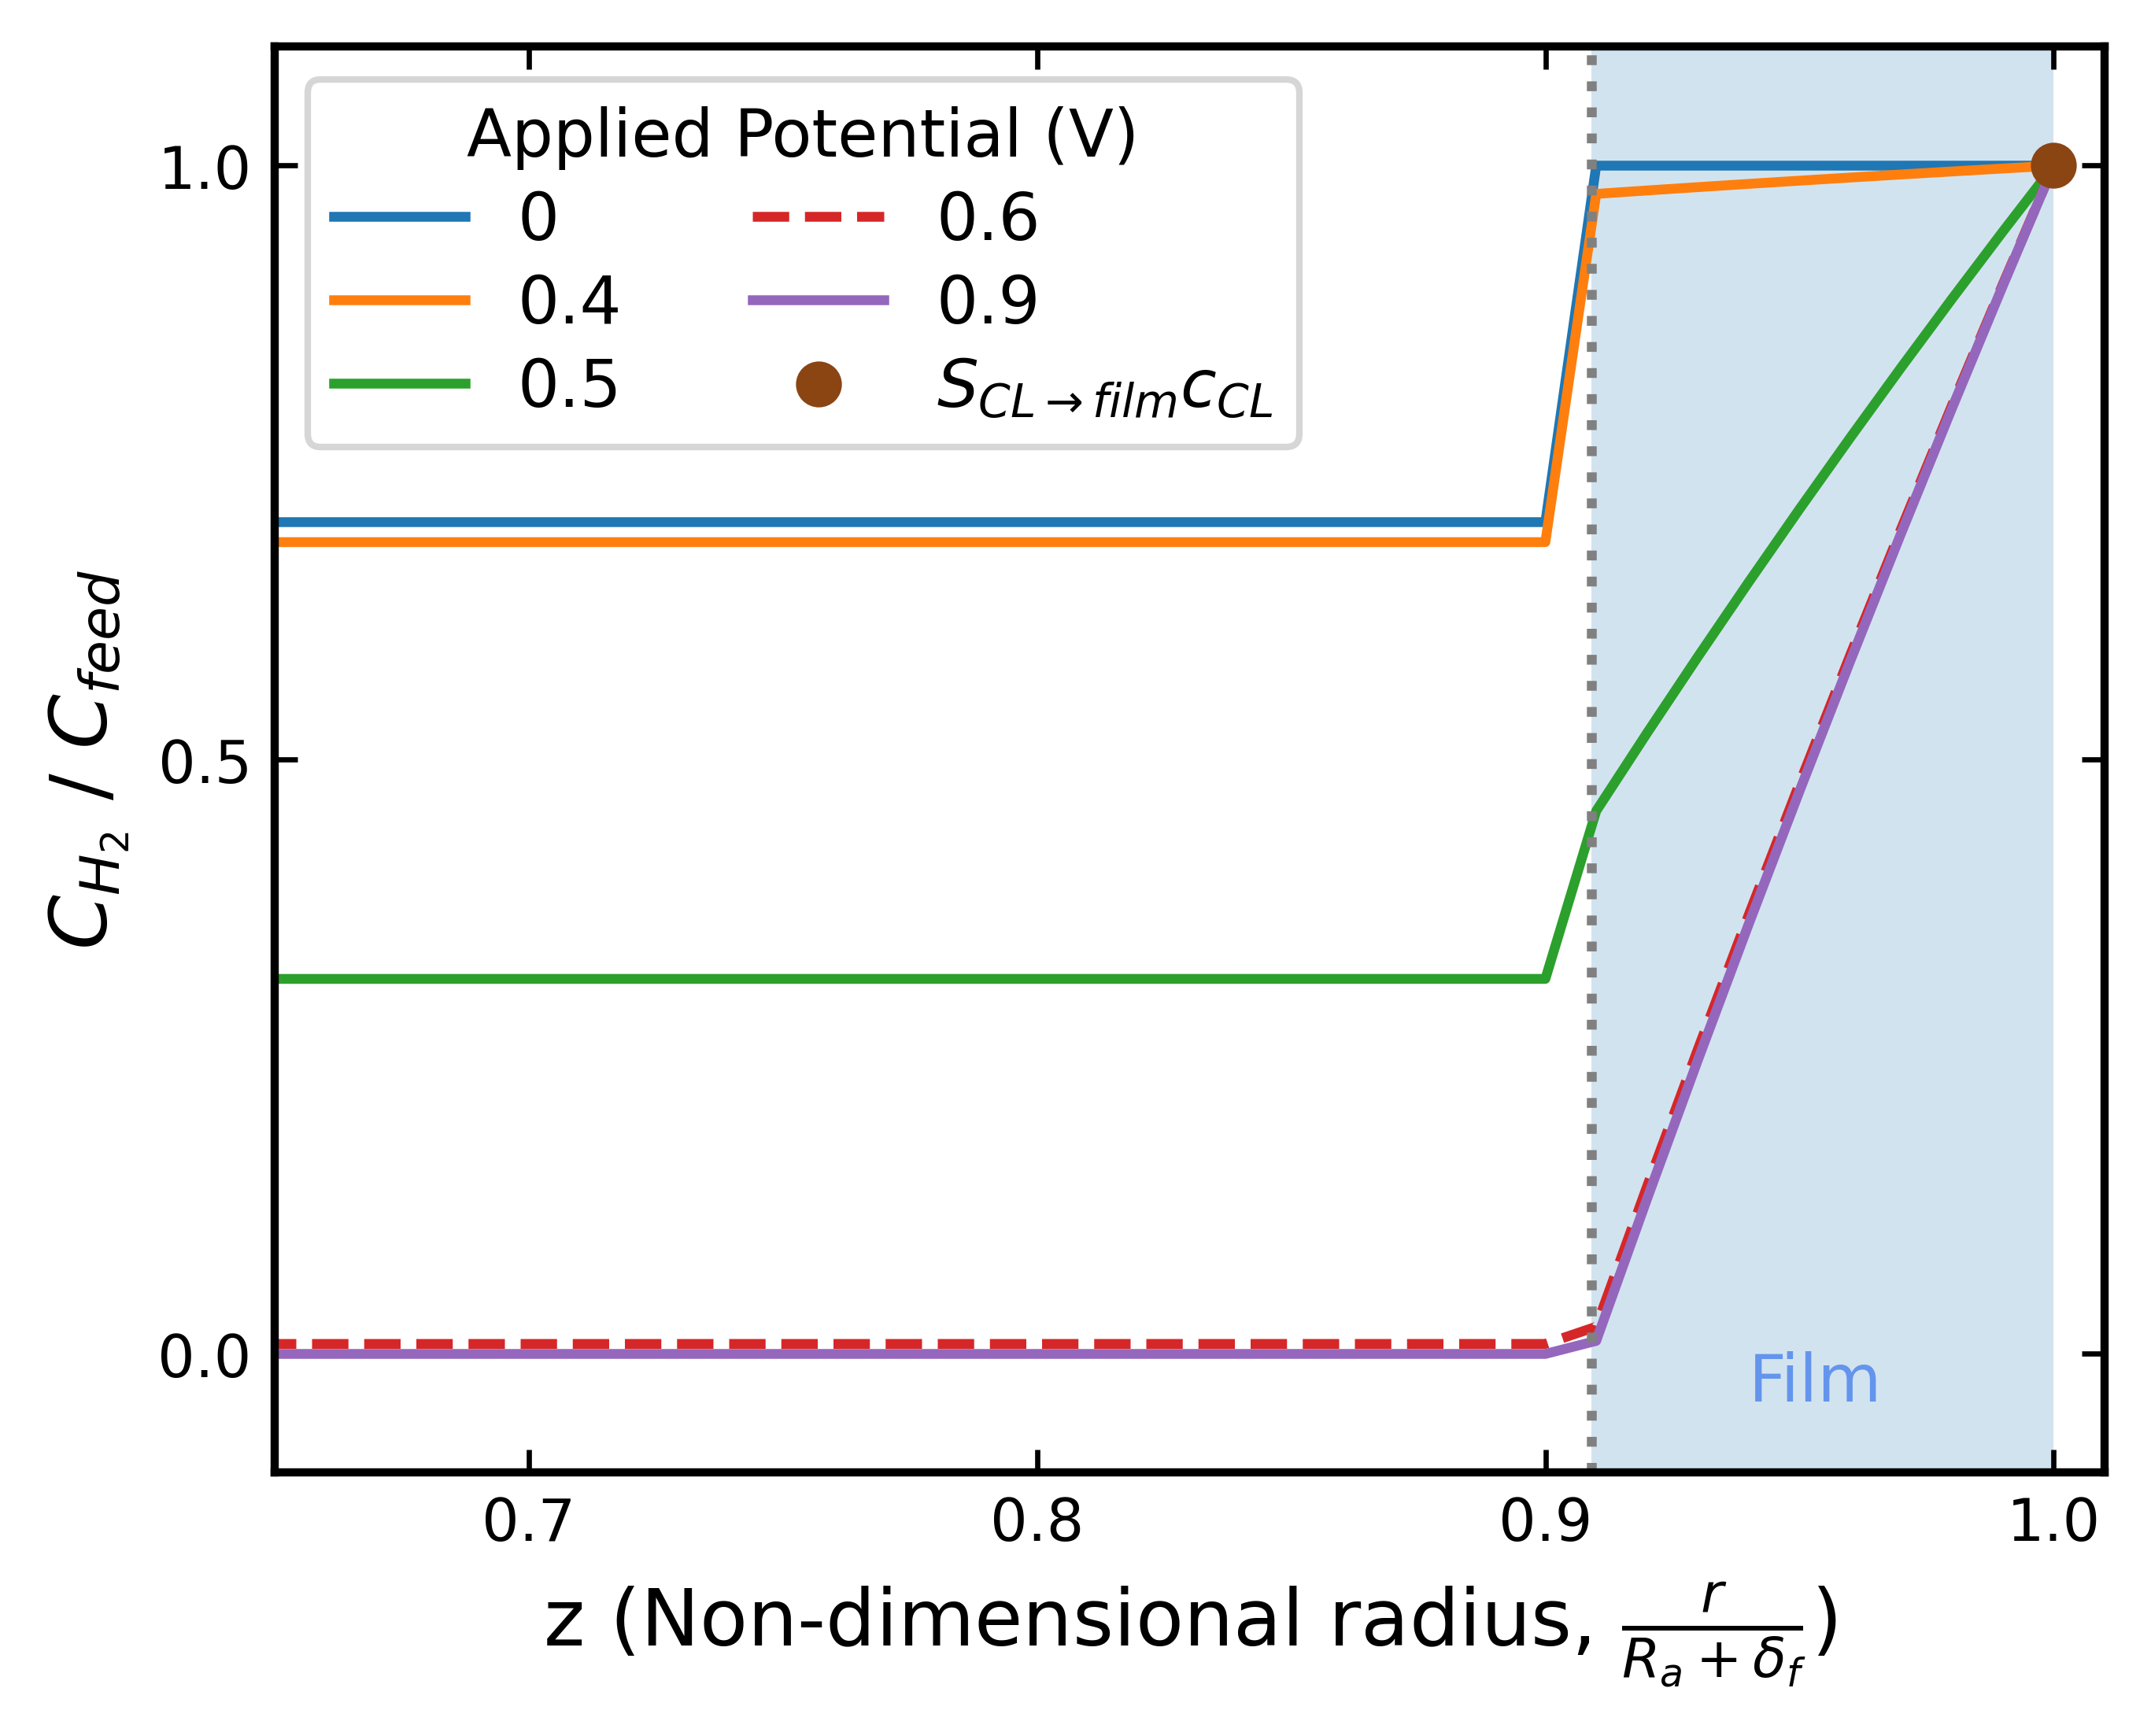

In [320]:
#Creating figure, specifying the dpi and size
fig, axs = plt.subplots(dpi=600,figsize=(5,4))

#Specifying tick marks are facing inward and on all sides and the size of the tick labels
axs.axes.tick_params(axis="x", direction="in",top=True, labelsize=9)
axs.axes.tick_params(axis="y", direction="in",right=True, labelsize=9)

#This specifies the thickness of the boarder. Thick boarders look nice.
[x.set_linewidth(1.25) for x in axs.spines.values()]

#This specifies the number of tick marks on the x and y axis
axs.locator_params(axis="x", nbins=4)
axs.locator_params(axis="y", nbins=4)

# for ch2 in cH2_z:
#     axs.plot(z, np.divide(ch2, c_feed))
for E in E_list:
    cH2_agg, cH2_film = c_internal(E=E)
    internal_c = np.append(cH2_film, cH2_agg)
    if E==0.6:
        axs.plot(z, np.divide(internal_c, S_bulk_film*c_feed), label=str(E), linestyle='--')
    else:
        axs.plot(z, np.divide(internal_c, S_bulk_film*c_feed), label=str(E))
plt.axvline(R_a/(R_a + delta_f), color='grey', linestyle=':')
axs.axvspan(R_a/(R_a+delta_f), 1, alpha=0.2)
plt.text(0.94, -0.04, 'Film', color='cornflowerblue')
axs.plot(1, 1, 'o', label=r'$S_{CL \rightarrow film} c_{CL}$', color='saddlebrown')

#Axes limits, title, and size
axs.set_xlim(0.65, 1.01)
axs.set_ylim(-0.1, 1.1)
axs.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axs.set_xlabel(r'z (Non-dimensional radius, $\frac{r}{R_a + \delta_f}$)', fontsize=12)
axs.set_ylabel(r'$C_{H_2}$ / $C_{feed}$', fontsize=12)

labels = np.append(E_list, 'Film-agg')
axs.legend(loc='upper left', title='Applied Potential (V)', ncol=2, labelspacing=0.3)
